In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [2]:
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation
from Utils.numerical_utils import quadratic_function as expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG
import numpy as np
torch.set_default_dtype(torch.float64)

# Setup

## simple version

In [ ]:
from tqdm.notebook import tqdm
def estimate_key_info(tester, n_iter=20, max_n_samples=int(1e4), range_n_points=10):
    n_points_space = torch.logspace(torch.log10(torch.tensor(1)), torch.log10(torch.tensor(max_n_samples)), 
                                    range_n_points, dtype=torch.int)
    kl_hist = []
    alpha_2_hist = []
    for n_samples in tqdm(n_points_space):
        kl_list = []
        alpha_2_list = []
        for i in range(n_iter):
            batch_size = int(n_samples)
            n_samples = int(n_samples)
            x_samples, log_q_x = tester.learnt_sampling_dist(batch_size)
            log_p_x = tester.target_dist.log_prob(x_samples)
            #DReG_alpha_2_loss = tester.dreg_alpha_divergence_loss(x_samples, log_q_x, log_p_x))
            #kl_loss = KL_loss(x_samples_not_used, log_q_x, log_p_x)
            kl_MC_estimate = tester.kl_MC_estimate(n_samples)
            alpha_2_MC_estimate = tester.alpha_divergence_MC_estimate(n_samples)
            kl_list.append(kl_MC_estimate)
            alpha_2_list.append(alpha_2_MC_estimate)
        kl_hist.append(kl_list)
        alpha_2_hist.append(alpha_2_list)
    return np.array(kl_hist), np.array(alpha_2_hist), n_points_space

## More complicated function

In [3]:
def kl_MC_estimator(log_q_x, log_p_x):
    kl = log_q_x - log_p_x
    kl_loss = torch.mean(kl)
    return kl_loss.item()


def alpha_divergence_MC_estimator(log_q_x, log_p_x, alpha=2):
    alpha_one_minus_alpha_sign = torch.sign(torch.tensor(alpha * (1 - alpha)))
    N = torch.tensor(log_p_x.shape[0])
    log_alpha_divergence = -alpha_one_minus_alpha_sign * \
                           (torch.logsumexp(alpha*(log_p_x - log_q_x), dim=-1) - torch.log(N))
    return log_alpha_divergence.item()

In [4]:
def get_probs(target, n_points, batch_size=int(1e5)):
    batch_size = min(n_points, batch_size)
    n_batches = n_points/batch_size
    assert n_batches % 1 == 0
    log_p_x_list = []
    log_q_x_list = []
    for i in range(int(n_batches)):
        with torch.no_grad():
            x_samples, log_q_x = tester.learnt_sampling_dist(batch_size)
            log_p_x = tester.target_dist.log_prob(x_samples)
        log_p_x = log_p_x.detach()
        log_q_x = log_q_x.detach()
        log_p_x_list.append(log_p_x)
        log_q_x_list.append(log_q_x)
    return torch.cat(log_q_x_list), torch.cat(log_p_x_list)

In [5]:
from tqdm.notebook import tqdm
def estimate_key_info(tester, max_n_samples=1e6, min_n_samples=10, n_runs_max=10):
    kl_hist = []
    alpha_2_hist = []
    n_points_space = torch.logspace(torch.log10(torch.tensor(min_n_samples)), torch.log10(torch.tensor(max_n_samples)), 
                                    int(np.log10(max_n_samples) - np.log10(min_n_samples)+1), dtype=torch.int)
    batch_size = int(max_n_samples*n_runs_max)
    log_q_x, log_p_x = get_probs(target, batch_size)
    for n_samples in tqdm(n_points_space):
        kl_list = []
        alpha_2_list = []
        n_iter = batch_size / n_samples
        assert n_iter % 1 < 1e-3
        n_iter = int(n_iter)
        for i in range(n_iter):
            n_samples = int(n_samples)
            log_q_x_slice = log_q_x[n_samples*i: n_samples*(i+1)]
            log_p_x_slice = log_p_x[n_samples*i: n_samples*(i+1)]
            kl_MC_estimate = kl_MC_estimator(log_q_x_slice, log_p_x_slice)
            alpha_2_MC_estimate = alpha_divergence_MC_estimator(log_q_x_slice, log_p_x_slice)
            kl_list.append(kl_MC_estimate)
            alpha_2_list.append(alpha_2_MC_estimate)
        kl_hist.append(kl_list)
        alpha_2_hist.append(alpha_2_list)
    return kl_hist, alpha_2_hist, n_points_space

In [6]:
def get_vars(hist_list):
    return [np.var(run_list) for run_list in hist_list]

In [11]:
def get_means(hist_list):
    return [np.mean(run_list) for run_list in hist_list]

In [18]:
def get_coeff_of_variation(hist_list):
    return [np.std(run_list)/np.abs(np.mean(run_list)) for run_list in hist_list]

# Easy problem

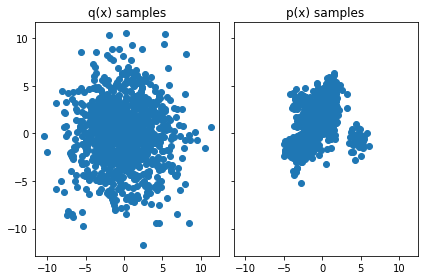

In [7]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
dim = 2
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=2, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [8]:
kl_hist, alpha_2_hist, n_points_space = estimate_key_info(tester, int(1e3))

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
#kl_hist, alpha_2_hist, n_points_space = estimate_key_info(tester, n_iter=10, max_n_samples=int(1e3), 
#                                                          min_n_samples=10, range_n_points=5)

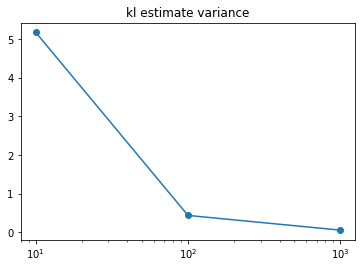

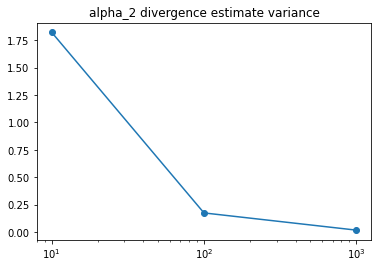

In [11]:
plt.figure()
plt.plot(n_points_space, get_vars(kl_hist), "o-")
plt.xscale("log")
plt.title("kl estimate variance")
plt.figure()
plt.plot(n_points_space, get_vars(alpha_2_hist), "o-")
plt.title("alpha_2 divergence estimate variance")
plt.xscale("log")

# Harder Problem

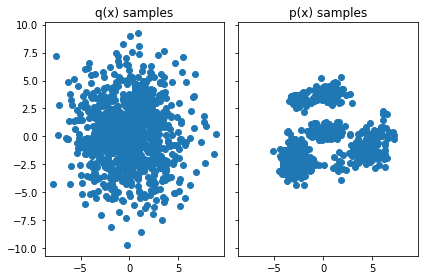

In [12]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
dim = 3
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [19]:
kl_hist, alpha_2_hist, n_points_space = estimate_key_info(tester, int(1e6), min_n_samples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

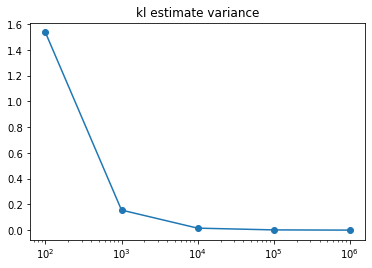

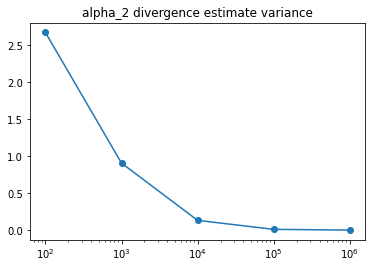

In [20]:
plt.figure()
plt.plot(n_points_space, get_vars(kl_hist), "o-")
plt.xscale("log")
plt.title("kl estimate variance")
plt.figure()
plt.plot(n_points_space, get_vars(alpha_2_hist), "o-")
plt.title("alpha_2 divergence estimate variance")
plt.xscale("log")

# Harder harder Problem

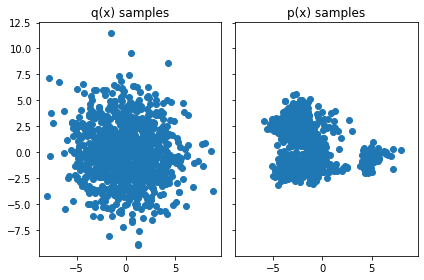

In [7]:
torch.manual_seed(0) # 0 breaks it within 1000 epochs
dim = 6
n_samples_estimation = int(1e4)
target = MoG(dim=dim, n_mixes=10, min_cov=0, loc_scaling=3)
true_expectation = MC_estimate_true_expectation(target, expectation_function, int(1e6))
torch.manual_seed(1)
learnt_sampler = FlowModel(x_dim=dim, n_flow_steps=3, scaling_factor=5.0) #, flow_type="RealNVP")
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG", lr=1e-3)
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)
samples_fig_before = plot_samples(tester) # this just looks at 2 dimensions

In [8]:
kl_hist, alpha_2_hist, n_points_space = estimate_key_info(tester, int(1e6), min_n_samples=100)

  0%|          | 0/5 [00:00<?, ?it/s]

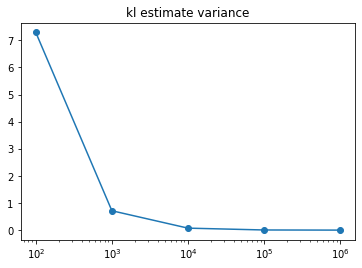

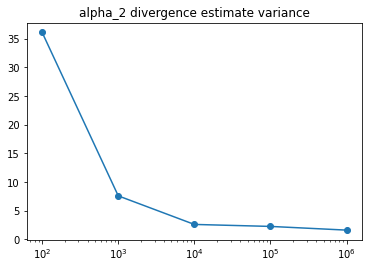

In [9]:
plt.figure()
plt.plot(n_points_space, get_vars(kl_hist), "o-")
plt.xscale("log")
plt.title("kl estimate variance")
plt.figure()
plt.plot(n_points_space, get_vars(alpha_2_hist), "o-")
plt.title("alpha_2 divergence estimate variance")
plt.xscale("log")

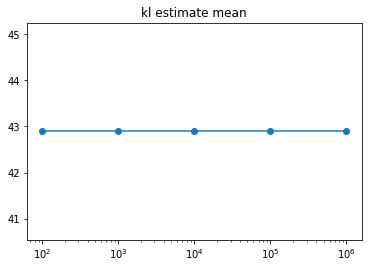

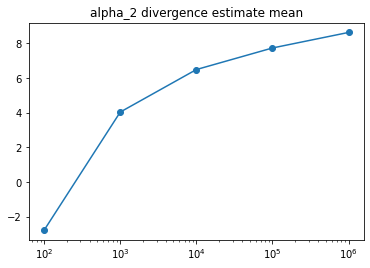

In [12]:
plt.figure()
plt.plot(n_points_space, get_means(kl_hist), "o-")
plt.xscale("log")
plt.title("kl estimate mean")
plt.figure()
plt.plot(n_points_space, get_means(alpha_2_hist), "o-")
plt.title("alpha_2 divergence estimate mean")
plt.xscale("log")

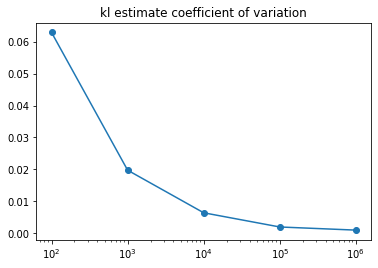

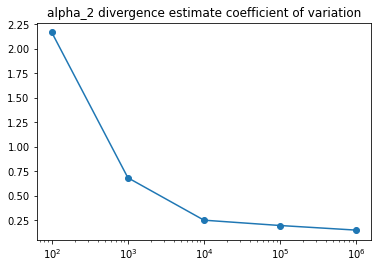

In [20]:
plt.figure()
plt.plot(n_points_space, get_coeff_of_variation(kl_hist), "o-")
plt.xscale("log")
plt.title("kl estimate coefficient of variation")
plt.figure()
plt.plot(n_points_space, get_coeff_of_variation(alpha_2_hist), "o-")
plt.title("alpha_2 divergence estimate coefficient of variation")
plt.xscale("log")